# Explore Kaastra 17

Can we see how well the [On the use of C-stat in testing models for X-ray spectra (Kaastra 17)](https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..51K/abstract) approximation works, and how to test it in Sherpa?

In [1]:
import sherpa
sherpa.__version__

'4.17.0'

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sherpa.astro import ui
from sherpa.utils.logging import SherpaVerbosity

The following code gives us three main routines (the aim is to add this functionality to the [CIAO contributed scripts](https://cxc.harvard.edu//ciao/download/scripts/) package, but
for now these are still experimental):

- `calc_cstat_gof_kaastra17`, which calculates the expected mean and variance for the `CStat` statistic for the given **model**,
- `show_cscat_gof_kaastra17`, which takes the `calc_cstat_gof_kaastra17` results and presents them in a "nice" form, along with the current statistic value
- and `simulate_stats` which will simulate a dataset using the current model - assuming Poisson statistics - and calculate the `CStat` value.

In [3]:
"""

How to exlpore the Kaastra 17 result?

Calculate an approxmate goodness-of-fit for the CSTAT
statistic using the results of Kaastra 2017 (A&A 605, A51)

https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..51K/abstract

The calculation requires the expected model values for each bin.

"""

from collections.abc import Callable
from dataclasses import dataclass
import logging

import numpy as np
import numpy.typing as npt

from sherpa.astro import ui
from sherpa.data import Data, Data1D
from sherpa.fit import Fit
from sherpa.models.model import ArithmeticConstantModel, Model
from sherpa.stats import Stat, CStat
from sherpa.utils import sao_fcmp, send_to_pager
from sherpa.utils.random import RandomType, poisson_noise
from sherpa.utils.types import IdType


# Use the sherpa logging instance.
lgr = logging.getLogger("sherpa")


def get_fake_info(data: Data,
                  model: Model
                  ) -> tuple[Data1D, ArithmeticConstantModel]:
    """Create the data and models to use to simulate the data.

    Parameters
    ----------
    data, model
       The dataset and model to simulate

    Returns
    -------
    faked_data, faked_model
       The basic data and model used for the simulations.

    """

    actual_data, _, _ = data.to_fit()
    actual_model = data.eval_model_to_fit(model)

    fake_x = np.arange(len(actual_data))
    fake_data = Data1D("faked_data", fake_x, actual_data)
    fake_model = ArithmeticConstantModel(name="faked_model",
                                         val=actual_model)
    return fake_data, fake_model


def simulate_model_stats(data: Data,
                         model: Model,
                         stat: Stat,
                         niter: int,
                         method: Callable | None = None,
                         rng: RandomType | None = None
                         ) -> np.ndarray:
    """Simulate the data from the model and evaluate the statistic.

    Use the current model to simulate data - using the method call -
    and then evaluate the statistic. Repeat niter times and return
    the statistic values.

    Parameters
    ----------
    data
       The data.
    model
       The model fit to the data.
    stat
       The statistic object.
    niter
       The number of iteratations.
    method
       If None, the default, then the data is simulated using the
       `sherpa.utils.random.poisson_noise` routine. If set, it must be
       a callable that takes a ndarray of the predicted values and an
       optional rng argument that takes a NumPy random generator, and
       returns a ndarray of the same size with the simulated data.
    rng
       The RNG (or None) to send to method.

    Returns
    -------
    stats
       An array with niter statistic values.

    Notes
    -----

    This is only going to work reliably with Cash or CStat
    statistics. The Chi-Square statistics require an error array and
    it's unclear how best to calculate this. The WStat statistic
    is unlikley to work, thanks to the background handling, but
    it has not been tested.

    Should the data be re-grouped? This has large consequences for how
    the code is called but also the interpretation of the results.

    """

    if niter < 1:
        raise ValueError("niter must be >= 1")

    predictor = poisson_noise if method is None else method

    fake_data, fake_model = get_fake_info(data, model)

    out = np.full(niter, np.nan)
    for idx in range(niter):
        # Simulate the data based on the model prediction
        fake_data.y = predictor(fake_model.val, rng=rng)
        out[idx] = stat.calc_stat(fake_data, fake_model)[0]

    return out


def validate_model_stats(f: Fit,
                         prefix: str) -> None:
    """Check we can match the expected statistic.

    Parameters
    ----------
    f
       The fit object
    prefix
       The prefix for the warning message that is displayed if
       there is a mis-match.

    """

    lgr.debug(f"Checking statistic matches for {f.stat.name}")

    # The expected statistic can be calculated from the fit object.
    #
    expected = f.calc_stat()

    fake_data, fake_model = get_fake_info(f.data, f.model)
    got = f.stat.calc_stat(fake_data, fake_model)[0]

    # For now use a fairly "relaxed" tolerance of 10^-4.
    # Do not distinguish between "too large" or "too small".
    #
    if sao_fcmp(expected, got, tol=1e-4) == 0:
        return

    msg = f"{prefix} - expected statistic {expected} but " + \
        f"calculated {got}"
    lgr.warning(msg)


def simulate_stats(id: IdType | None = None,
                   *otherids: IdType,
                   bkg_only: bool = False,
                   niter: int = 1000,
                   method: Callable | None = None
                   ) -> np.ndarray:
    """Simulate data using the current model and calculate the statistic.

    Take the current model predictions and use them to simulate
    a data set and calculate the statistic value.

    Parameters
    ----------
    id : int or str, optional
       The data set that provides the data. If not given then all data
       sets with an associated model are fit simultaneously.
    *otherids : sequence of int or str, optional
       Other data sets to use in the calculation.
    bkg_only : bool, optional
       This keyword-only argument should be set if only the background
       fits - e.g. from a call to `fit_bkg` - should be analysed.
    niter : int, optional
       The number of iterations.
    method
       If None, the default, then the data is simulated using the
       `sherpa.utils.random.poisson_noise` routine. If set, it must be
       a callable that takes a ndarray of the predicted values and an
       optional rng argument that takes a NumPy random generator, and
       returns a ndarray of the same size with the simulated data.

    Returns
    -------
    stats
       An array of the predicted statistic value.

    Notes
    -----

    The model evaluation is over the noticed bins only, and applies
    the selected grouping column (if applicable). This means that the
    simulation will be done on the grouped channel, and not on the
    individual channels and then combined.

    This will not work with the WStat statistic.

    """

    # What identifiers should be used? This uses internals of the
    # Sherpa UI API.
    #
    session = ui._session

    if bkg_only:
        getfit = session._get_bkg_fit
    else:
        getfit = session._get_fit

    # Should this run within SherpaVerbosity("ERROR")? This will avoid
    # the user seeing warnings (e.g. background is being ignored) but
    # there is a strong argument to say they should see these warnings
    # here.
    #
    allids, f = getfit(id, otherids, numcores=1)

    # Let the user know what identifiers are in use.  Use allids in
    # case it has more entries in then id+otherids (e.g. if id is
    # None).
    #
    if len(allids) == 1:
        names = allids[0]
        msg = f"Using fit results from dataset: {names}"
        prefix = f"Dataset: {names}"
    else:
        names = str(allids).strip("[]()")
        msg = f"Using fit results from datasets: {names}"
        prefix = f"Datasets: {names}"

    lgr.info(msg)

    # Let the user know if there's a problem calculating the
    # statistic, as the current approach may break in certain
    # situations (e.g. maybe WStat).
    #
    validate_model_stats(f, prefix)

    rng = session.get_rng()
    return simulate_model_stats(f.data, f.model, f.stat,
                                niter=niter, method=method, rng=rng)

def process_range(mu: np.ndarray,
                  out: np.ndarray,
                  func: Callable[[np.ndarray], np.ndarray],
                  lo: float,
                  hi: float | None
                  ) -> None:
    """Select those mu values within [lo, hi) and fill the out values.

    Parameters
    ----------
    mu
       The model prediction values, in counts. 1D.
    out
       The array to be filled in by func. It must match mu in shape.
    func
       Given the subset of mu that matches [lo, hi), calculate the
       expected values and return them.
    lo
       The minimum value; this is "lo < mu" unless
       lo is 0, when it's "lo <= mu". lo is >= 0.
    hi
       The maximum value, if set. This is always "mu <= hi".
       hi is > lo when not None.

    """

    if lo == 0.0:
        idx = mu >= 0
    else:
        idx = mu > lo

    if hi is not None:
        idx &= (mu <= hi)

    # No items selected
    if not idx.any():
        return

    # Calculate and store the values.
    out[idx] = func(mu[idx])


def estimate_mean(mu: npt.ArrayLike) -> np.ndarray:
    """Use equations 8-12 of Kaastra 2017 to estimate cstat.

    Parameters
    ----------
    mu
       The expected (model) prediction, in counts.

    Returns
    -------
       The expected Cstat value (an approximation).

    """

    muvals = np.array(mu)

    def v1(m1):
        return -0.25 * m1**3 + 1.38 * m1**2 - 2 * m1 * np.log(m1)

    def v2(m2):
        return -0.00335 * m2**5 + 0.04259 * m2**4 \
            - 0.27331 * m2**3 + 1.381 * m2**2 - 2 * m2 * np.log(m2)

    def v3(m3):
        return 1.019275 + 0.1345 * m3**(0.461 - 0.9 * np.log(m3))

    def v4(m4):
        return 1.00624 + 0.604 / m4**1.68

    def v5(m5):
        return 1 + 0.1649 / m5 + 0.226 / m5**2

    # Model values < 0 are just set to NaN for now.
    out = np.full(muvals.shape, np.nan)

    process_range(muvals, out, v1, 0, 0.5)
    process_range(muvals, out, v2, 0.5, 2)
    process_range(muvals, out, v3, 2, 5)
    process_range(muvals, out, v4, 5, 10)
    process_range(muvals, out, v5, 10, None)
    return out


kfact = {0: 1, 1: 1, 2: 2, 3: 6, 4: 24}


def pk(k: int, mu: np.ndarray) -> np.ndarray:
    """P_k(mu) = exp(-mu) my^k / k!

    This requires k=0, 1, 2, 3, or 4.
    """

    return np.exp(-mu) * mu**k / kfact[k]


def estimate_variance(mu: npt.ArrayLike) -> np.ndarray:
    """Use equations 13-22 of Kaastra 2017 to estimate cstat variance.

    Parameters
    ----------
    mu
       The expected (model) prediction, in counts.

    Returns
    -------
       The expected variance of the Cstat value (an approximation).

    """

    muvals = np.array(mu)

    # Model values < 0 are just set to NaN for now.
    out = np.full(muvals.shape, np.nan)

    def v1(m1):
        sv = pk(0, m1) * m1**2
        for k in range(1, 5):
            sv += pk(k, m1) * (m1 - k + k * np.log(k / m1))**2

        sv *= 4

        # Convert from Sv to Cv using Cv = Sv - Ce^2
        return sv - estimate_mean(m1)**2

    def v2(m2):
        return -262 * m2**4 + 195 * m2**3 - 51.24 * m2**2 + \
            4.34 * m2 + 0.77005

    def v3(m3):
        return 4.23 * m3**2 - 2.8254 * m3 + 1.12522

    def v4(m4):
        return -3.7 * m4**3 + 7.328 * m4**2 - 3.6926 * m4 + 1.20641

    def v5(m5):
        return 1.28 * m5**4 - 5.191 * m5**3 + 7.666 * m5**2 - \
            3.5446 * m5 + 1.15431

    def v6(m6):
        return 0.1125 * m6**4 - 0.641 * m6**3 + 0.859 * m6**2 + \
            1.0914 * m6 - 0.05748

    def v7(m7):
        return 0.089 * m7**3 - 0.872 * m7**2 + 2.8422 * m7 - 0.67539

    def v8(m8):
        return 2.12336 + 0.012202 * m8**(5.717 - 2.6 * np.log(m8))

    def v9(m9):
        return 2.05159 + 0.331 * m9**(1.343 - np.log(m9))

    def v10(m10):
        return 12 / m10**3 + 0.79 / m10**2 + 0.6747 / m10 + 2

    process_range(muvals, out, v1, 0, 0.1)
    process_range(muvals, out, v2, 0.1, 0.2)
    process_range(muvals, out, v3, 0.2, 0.3)
    process_range(muvals, out, v4, 0.3, 0.5)
    process_range(muvals, out, v5, 0.5, 1)
    process_range(muvals, out, v6, 1, 2)
    process_range(muvals, out, v7, 2, 3)
    process_range(muvals, out, v8, 3, 5)
    process_range(muvals, out, v9, 5, 10)
    process_range(muvals, out, v10, 10, None)

    return out


def expected_cstat_raw(mu: np.ndarray
                       ) -> tuple[float, float]:
    """What is the Kaastra 2017 approximation for the given model?

    Parameters
    ----------
    mu
       The model values, per bin.

    Returns
    -------
    expected, variance
       The expected CStat value and its variance.

    """

    ce = estimate_mean(mu)
    cv = estimate_variance(mu)

    mean = ce.sum()
    variance = cv.sum()
    return float(mean), float(variance)


def expected_cstat(data: Data,
                   model: Model
                   ) -> tuple[float, float]:
    """Calculate the expected CStat from Kaastra 2017.

    Calculate an approxmate goodness-of-fit for the CSTAT
    statistic using the results of
    `Kaastra 2017 (A&A 605, A51)
    <https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..51K/abstract>`_.

    Parameters
    ----------
    data
       The data
    model
       The model fit to the data.

    Returns
    -------
    expected, variance
       The expected CStat value and its variance.

    """

    mu = data.eval_model_to_fit(model)
    return expected_cstat_raw(mu)


@dataclass(frozen=True)
class _Kaastra17:
    """Store Kaastra 2017 information."""

    ids: list[IdType]
    fit: Fit
    mean: float
    variance: float


def _calc_cstat_gof_kaastra17(id: IdType | None = None,
                              *otherids: IdType,
                              bkg_only: bool = False
                              ) -> _Kaastra17:
    """Internal calculation of CStat using Kaastra 2017.

    Parameters
    ----------
    id : int or str, optional
       The data set that provides the data. If not given then all data
       sets with an associated model are fit simultaneously.
    *otherids : sequence of int or str, optional
       Other data sets to use in the calculation.
    bkg_only : bool, optional
       This keyword-only argument should be set if only the background
       fits - e.g. from a call to `fit_bkg` - should be analysed.

    Returns
    -------
    mapping
       The mean and variance calculated following Kaastra 2017,
       along with other useful information.

    """

    # What identifiers should be used? This uses internals of the
    # Sherpa UI API.
    #
    session = ui._session

    if bkg_only:
        func = session._get_bkg_fit
    else:
        func = session._get_fit

    ids, f = func(id, otherids, numcores=1)
    mean, var = expected_cstat(data=f.data, model=f.model)
    return _Kaastra17(ids=list(ids), fit=f, mean=mean, variance=var)


def calc_cstat_gof_kaastra17(id: IdType | None = None,
                             *otherids: IdType,
                             bkg_only: bool = False
                             ) -> tuple[float, float]:

    """Calculate the Kaastra 2017 CSTAT goodness-of-fit estimate.

    Calculate an approxmate goodness-of-fit for the CSTAT
    statistic using the results of
    `Kaastra 2017 (A&A 605, A51)
    <https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..51K/abstract>`_.

    Parameters
    ----------
    id : int or str, optional
       The data set that provides the data. If not given then all data
       sets with an associated model are fit simultaneously.
    *otherids : sequence of int or str, optional
       Other data sets to use in the calculation.
    bkg_only : bool, optional
       This keyword-only argument should be set if only the background
       fits - e.g. from a call to `fit_bkg` - should be analysed.

    Returns
    -------
    cstat, variance
       The model-predicted CStat and variance, as calculated by
       Kaastra 2017.

    See Also
    --------
    show_cstat_gof_kaastra17

    Notes
    -----
    This code assumes the data has already been fit.

    """

    res = _calc_cstat_gof_kaastra17(id, *otherids,
                                    bkg_only=bkg_only)

    ids = res.ids
    if len(ids) == 1:
        msg = f"Using fit results from dataset: {ids[0]}"
    else:
        names = str(ids).strip("()[]")
        msg = f"Using fit results from datasets: {names}"

    lgr.info(msg)
    return res.mean, res.variance


def show_cstat_gof_kaastra17(id: IdType | None = None,
                             *otherids: IdType,
                             bkg_only: bool = False,
                             outfile = None,
                             clobber: bool = False
                             ) -> None:
    """Display the Kaastra 2017 CSTAT goodness-of-fit estimate.

    Calculate an approxmate goodness-of-fit for the CSTAT
    statistic using the results of
    `Kaastra 2017 (A&A 605, A51)
    <https://ui.adsabs.harvard.edu/abs/2017A%26A...605A..51K/abstract>`_.

    Parameters
    ----------
    id : int or str, optional
       The data set that provides the data. If not given then all data
       sets with an associated model are fit simultaneously.
    *otherids : sequence of int or str, optional
       Other data sets to use in the calculation.
    bkg_only : bool, optional
       This keyword-only argument should be set if only the background
       fits - e.g. from a call to `fit_bkg` - should be analysed.
    outfile : str, optional
       If not given the results are displayed to the screen, otherwise
       it is taken to be the name of the file to write the results to.
    clobber : bool, optional
       If `outfile` is not ``None``, then this flag controls whether
       an existing file can be overwritten (``True``) or if it raises
       an exception (``False``, the default setting).

    See Also
    --------
    calc_cstat_gof_kaastra17

    Notes
    -----
    This code assumes the data has already been fit.

    """

    res = _calc_cstat_gof_kaastra17(id, *otherids,
                                    bkg_only=bkg_only)

    out = []
    def msg(left, right):
        out.append(f"{left:20s} = {right}")

    ids = res.ids
    if len(ids) == 1:
        msg("Dataset", ids[0])
    else:
        idstr = str(ids).strip("()[]")
        msg("Datasets", idstr)

    msg("Statistic", res.fit.stat.name)

    c = res.fit.calc_stat()
    msg("  calculated", c)

    se = np.sqrt(res.variance)
    msg("  model prediction", f"{res.mean} +/- {se}")

    # The Kaastra approximations have relative errors of order 1e-4,
    # so restrict the number-of-sigma calculation to 4dp as we expect
    # separation values ~ 1.
    #
    diff = (c - res.mean) / se
    msg("  separation", f"{diff:.4g} sigma")

    txt = "\n".join(out)
    send_to_pager(txt, filename=outfile, clobber=clobber)

    if isinstance(res.fit.stat, CStat):
        return

    # Should this error out instead?
    lgr.warning(f"Expected CStat-based statistic, not {res.fit.stat.name}")

First, let's make this repeatable:

In [4]:
ui.set_rng(np.random.default_rng(82933))

We want to look at how the behaviour changes with signal strength; we can do this by varying the norm or by changing the number of channels (since it's signal-per-channel that matters).

The `create_data` routine sets the default dataset to be a PHA with `nbins` channels, and adds in a "perfect" response:

In [5]:
def create_data(nbins: int) -> None:
    """Create a PHA dataset (perfect response) with nbins channels."""

    idval = ui.get_default_id()
    ui.dataspace1d(idval, nbins, dstype=ui.DataPHA)
    ui.set_exposure(idval)

    egrid = np.linspace(0.1, 1.1, num=nbins + 1)
    elo = egrid[:-1]
    ehi = egrid[1:]

    ui.set_rmf(idval, ui.create_rmf(elo, ehi))
    ui.set_arf(idval, ui.create_arf(elo, ehi))

    # Do not normalize by the bin-width in data plots
    with SherpaVerbosity("ERROR"):
        ui.set_analysis(idval, quantity="energy", type="counts")

In [6]:
create_data(10)

We will use a "flat" model - a powerlaw with $\gamma$ set to 0 - to provide equal power per bin (this is unphysical for most cases, but makes it easier to think about the signal strength).

In [7]:
ui.set_source(ui.powlaw1d.pl)
pl.gamma = 0

The `renorm` routine lets us set the expected number of counts (total) for the model:

In [8]:
def renorm(cts: float) -> None:
    """Change the pl model so that it evaluates to cts counts."""

    norm = ui.calc_model_sum()
    pl.ampl.val *= cts / norm

In [9]:
renorm(100)

If we have done this right then the model should sum to 100:

In [10]:
ui.calc_model_sum()

100.00000000000001

We can see that the model normalization has been changed (as $\gamma=0$ the `ampl` value is easy to interpret, but this changes if the slope is changed):

In [11]:
ui.get_source()

<PowLaw1D model instance 'powlaw1d.pl'>

Given the model is flat and that there are 10 channels, the expected per-channel value is 10 (we do not use `ui.plot_model` here because the Matplotlib output is not particularly
informative because each bin has the same value):

In [12]:
ui.get_model_plot().y

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

We can create a realisation of the model with `ui.fake_pha` (no fit has been made, but as the data is simulated from the model it **should** be a reasonable representation of the data):

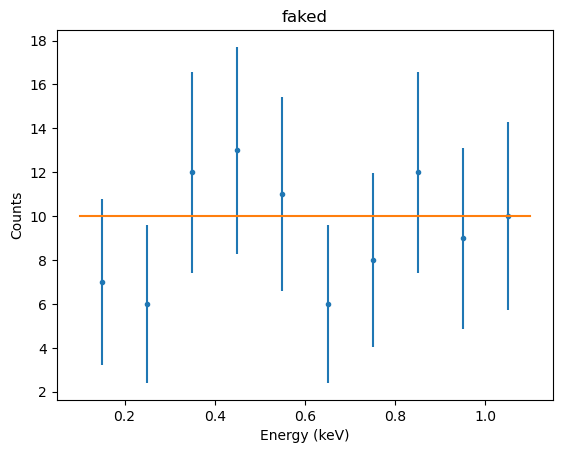

In [13]:
ui.fake_pha(1)
ui.plot_fit()

Note that the error bars are from a Gaussian approximation - in this case from the [`chi2gehrels`](https://cxc.cfa.harvard.edu/sherpa/ahelp/chi2gehrels.html) approximation.

The simulated data should be close to 100:

In [14]:
ui.calc_data_sum()

94.0

We are not going to fit the model (as this would complicate the process), but just assume that we are close to the best-fit location, *since the data is simulated from the model*:

In [15]:
ui.set_stat("cstat")
ui.calc_stat()

6.949679269565484

## **ASIDE**: what happens if we fit the model?

We create a new source model to fit (imaginatively called `pl_copy`) and try fitting it with just the amplitude free. We can see that the final statistic is not that much different (as one would hope):

In [16]:
ui.set_source(ui.powlaw1d.pl_copy)
pl_copy.gamma.set(0, frozen=True)

ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 674.722
Final fit statistic   = 6.58226 at function evaluation 17
Data points           = 10
Degrees of freedom    = 9
Probability [Q-value] = 0.680522
Reduced statistic     = 0.731362
Change in statistic   = 668.139
   pl_copy.ampl   94           +/- 9.71568     


In [17]:
ui.calc_stat()

6.5822551685755295

The original source expression is restored for the rest of the notebook.

In [18]:
ui.set_source(pl)
ui.calc_stat()

6.949679269565484

## **END ASIDE**

We can start with the `calc_cstat_gof_kaastra17` which takes the current model and predicts the expected mean and variance of the `CStat` value:

In [19]:
calc_cstat_gof_kaastra17()

Using fit results from dataset: 1


(10.188265440412508, 20.877536826716117)

The `show_cstat_gof_kaastra17` routine provides an overview, comparing the actual CStat value (the `calculated` line) to the predicted values from Kaastra 17, along with how far the calculated statistic is from the prediction:

In [20]:
show_cstat_gof_kaastra17()

Dataset              = 1
Statistic            = cstat
  calculated         = 6.949679269565484
  model prediction   = 10.188265440412508 +/- 4.5691943301545095
  separation         = -0.7088 sigma

So, this suggests that the current model is a reasonable match for the data, since the actual statistic value ($\sim 6.95$) is close to the model prediction
of $10.19 \pm 4.57$. This is also true if we use the "best-fit" statistic ($\sim 6.58$).

Is there a way to validate this?

We can use the `simulate_stats` routine to see how the statistic varies if we use the model to simulate the data - assuming Poisson statistics - 1000 times (this is actually a
parameter to `simulate_stats` but we use the default value of 1000 here):

In [21]:
with SherpaVerbosity("ERROR"):
    mean, var = calc_cstat_gof_kaastra17()
    xs = simulate_stats()

The `xs` values should be "flat" (with a fixed intrinsic scatter), and the values are the statistic value for each simulated dataset:

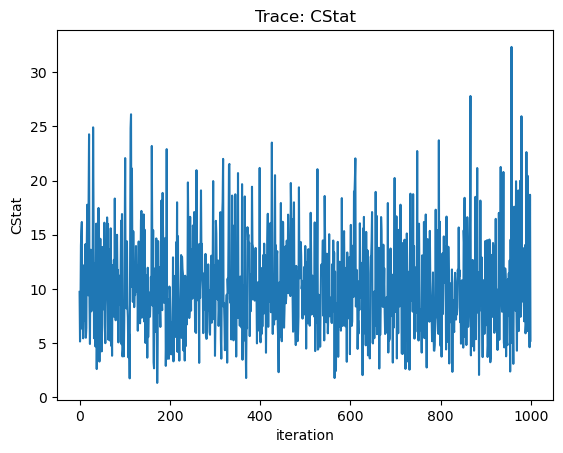

In [22]:
ui.plot_trace(xs, name="CStat")

The PDF shows a gaussian-like peak about a value of $\sim 10$:

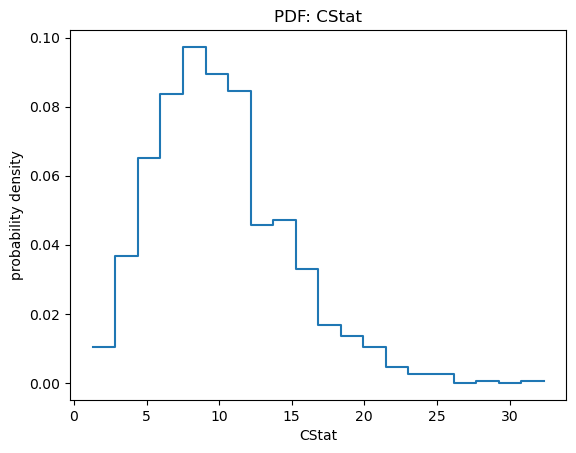

In [23]:
ui.plot_pdf(xs, bins=20, name="CStat", xlabel="CStat")

We can look at the cumulative density function, which automatically marks the median and "+/-" 1-sigma values from the distribution (with dashed verical lines), and add in a grey rectangle for the one-sigma values from Kaastra 17 (mean +/- $\sqrt(\rm{var})$, with a black line added for the mean value).

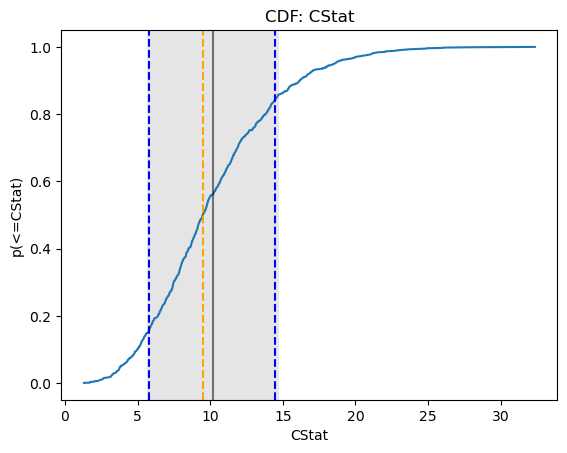

In [24]:
from matplotlib.patches import Rectangle

def add_rect(x1: float, x2: float,
             facecolor: str = "black",
             alpha: float = 0.1
            ) -> None:
    """Add a rectangle to the plot for x1-x2 (whole y range)"""

    y1, y2 = plt.ylim()
    r = Rectangle((x1, y1), x2 - x1, y2 - y1,
                  facecolor=facecolor, alpha=alpha)
    plt.gca().add_patch(r)

# This adds median and 1-sigma lines (vertical dashed lines) calculated from the
# distribution of xs values.
#
ui.plot_cdf(xs, name="CStat", xlabel="CStat")

# Draw the Kaastra 17 range
add_rect(mean - np.sqrt(var), mean + np.sqrt(var))
plt.axvline(mean, alpha=0.5, c='k');

So, the simulations predict essentially the same range as the Kaastra 17 approximation, at least for the one-sigma range about the median.

As I am about to repeat this process - simulate the model to estimate the statistic distribution, and then plot the results - let's come up with some helper routines. First something to run the simulation and store the results:

In [25]:
from dataclasses import dataclass

from sherpa.utils import get_error_estimates
from sherpa.utils.logging import SherpaVerbosity

@dataclass(frozen=True)
class Sample17:
    """Store Kaastra 17 results for a realization."""

    meanval: float
    """The predicted mean statistic from Kaastra 17"""
    stdval: float
    """The predicted standard deviation of the statistic from Kaastra 17"""

    niter: int
    """The number of samples."""
    mediansample: float
    """The median sample value"""
    lsigsample: float
    """The -1 sigma value from the samples"""
    usigsample: float
    """The +1 sigma value from the samples"""

    samples: np.ndarray
    """The statistic samples"""

    def _repr_html_(self) -> str:
        """The default displays the full samples array, which is a bit much"""
        out = f"<table><caption>For {self.niter} samples</caption><tdata>"
        out += f"<tr><td>Kaastra 17</td><td>{self.meanval} ({self.meanval - self.stdval} - {self.meanval + self.stdval})</td></tr>"
        out += f"<tr><td>Simulation</td><td>{self.mediansample}  ({self.lsigsample} - {self.usigsample}</td></tr>"
        out += f"<tr><td>samples</td><td>{self.samples.min()} - {self.samples.max()}</td></tr>"
        out += "</tdata></table>"
        return out


def resample_kaastra17(niter: int = 1000) -> Sample17:
    """Re-sample the data and calculate the Kaastra 17 results.

    This assumes the default dataset has data and model set up.
    """

    with SherpaVerbosity("ERROR"):
        meanval, varval = calc_cstat_gof_kaastra17()
        xs = simulate_stats(niter=niter)

    # Send in a copy so xs is not changed.
    med, lsig, usig = get_error_estimates(np.array(xs))
    
    return Sample17(meanval=meanval, stdval=np.sqrt(varval),
                    niter=niter, mediansample=med, lsigsample=lsig,
                    usigsample=usig, samples=xs)

As an example, we get:

In [26]:
resample_kaastra17()

Kaastra 17,10.188265440412508 (5.619071110257998 - 14.757459770567017)
Simulation,9.648623706683981 (5.951867925444008 - 14.516622925055266
samples,1.704378762115703 - 32.66605440077458


We can write a routine that creates these results and then displays them:

In [27]:
def view_kaastra17(label: str | None = None,
                   niter: int = 1000) -> None:
    """See how the Kaastra 17 approximations match the data."""
    
    res = resample_kaastra17(niter)
    ncts = int(ui.calc_model_sum() + 0.5)

    if label is None:
        nchans = len(ui.get_data().channel)
        label = f"{ncts} counts, {nchans} channels"
    
    lsig = res.meanval - res.stdval
    usig = res.meanval + res.stdval

    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})

    plt.sca(ax[0])
    ui.plot_cdf(res.samples, xlabel="CStat", clearwindow=False)
    add_rect(lsig, usig)
    _ = plt.axvline(res.meanval, alpha=0.5, c='k')
    _ = plt.title(label)

    plt.sca(ax[1])
    ui.plot_pdf(res.samples, xlabel="CStat", clearwindow=False)
    add_rect(lsig, usig)
    _ = plt.title("")

    plt.subplots_adjust(hspace=0.3)

We can try this out, varying the number of iterations - 100, 1000, and 10000 - just to see what happens:

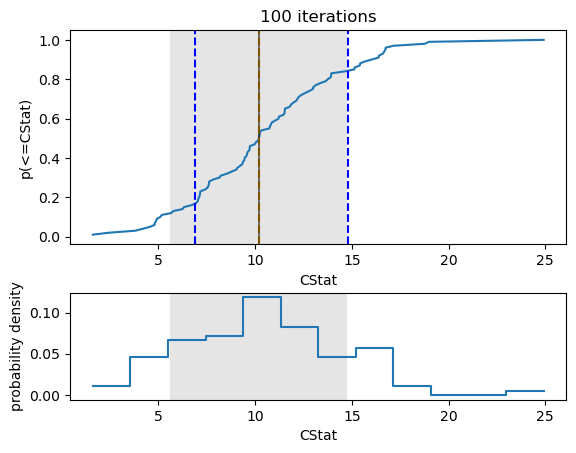

In [28]:
view_kaastra17(niter=100, label="100 iterations")

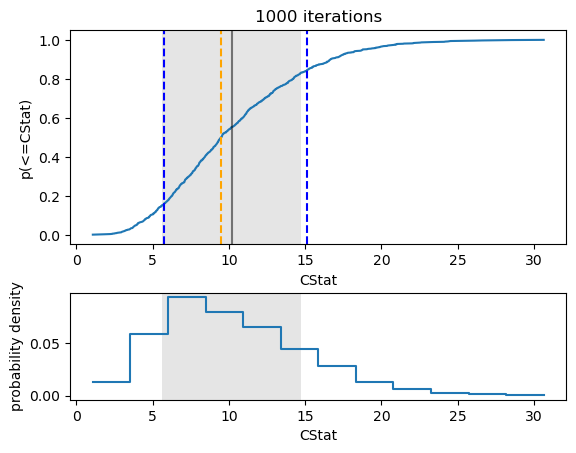

In [29]:
view_kaastra17(niter=1000, label="1000 iterations")

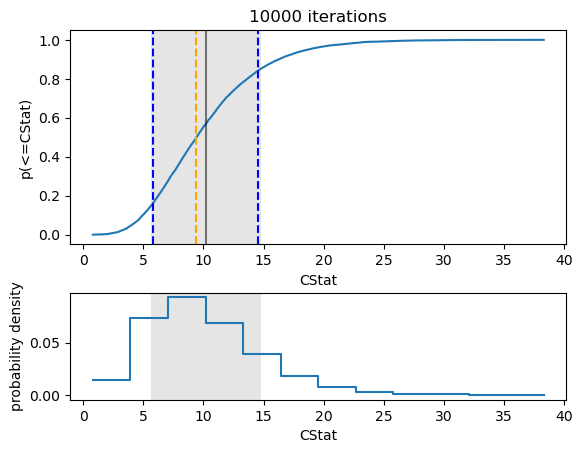

In [30]:
view_kaastra17(niter=10000, label="10000 iterations")

Using more iterations is obviuosly "better", but for these purposes a value somewhere around 1000 seems like a good choice. It also happens to be the default value for the parameter.

# How does the approximation change with signal strength and number of channels

The main feature of the Kaastra 17 approximation is the "signal per channel": is it large enough for the approximation to work? For the current data we have an equal signal level per channel, which makes it easy, as we pick

- Number of counts: 1000, 500, 100, 50, 10
- Number of channels: 10, 100, 1000

Since the results really just depend on the expected signal per bin, and the model is flat, then this could have been been done with just a single number of channels. However, it makes it easier to swap the model doing it this way.

In [31]:
def doit(nchan: int, ncts: int) -> None:
    create_data(nchan)
    renorm(ncts)
    view_kaastra17()

## 10 channels

So, the signal strength will vary from 1000 to 1 per channel here.

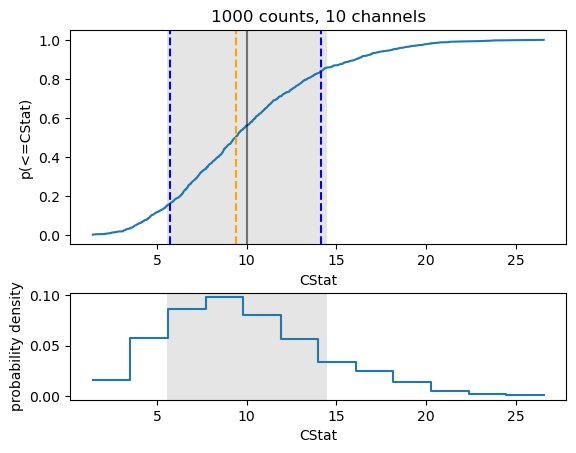

In [32]:
doit(10, 1000)

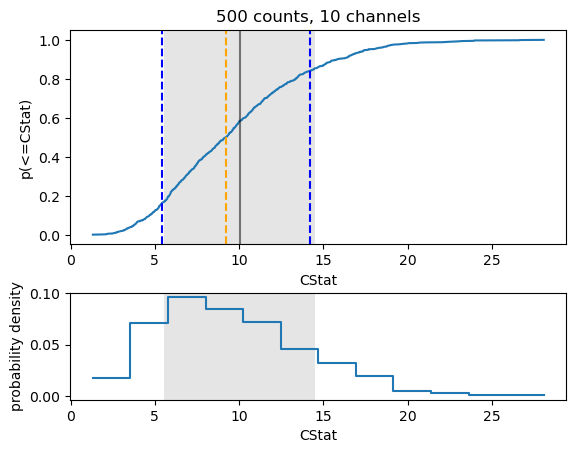

In [33]:
doit(10, 500)

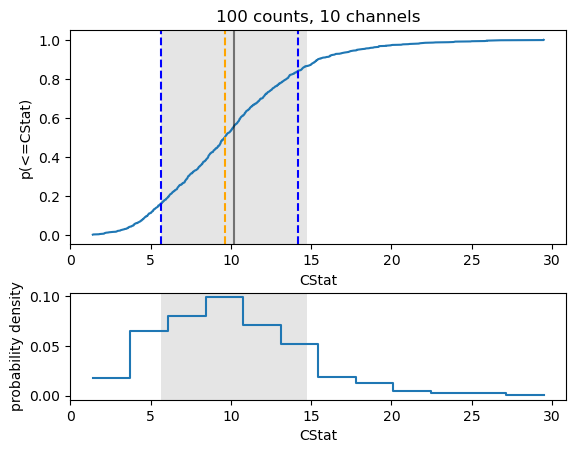

In [34]:
doit(10, 100)

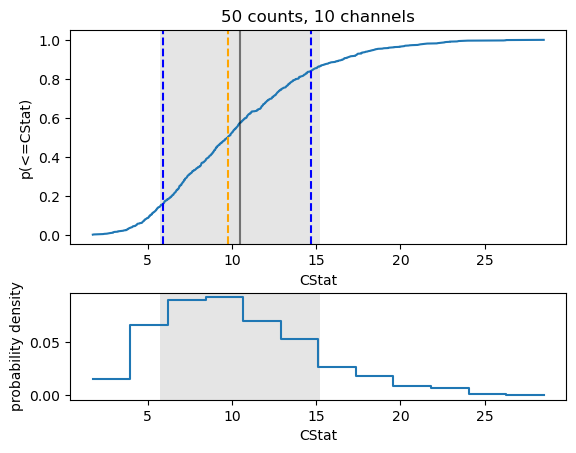

In [35]:
doit(10, 50)

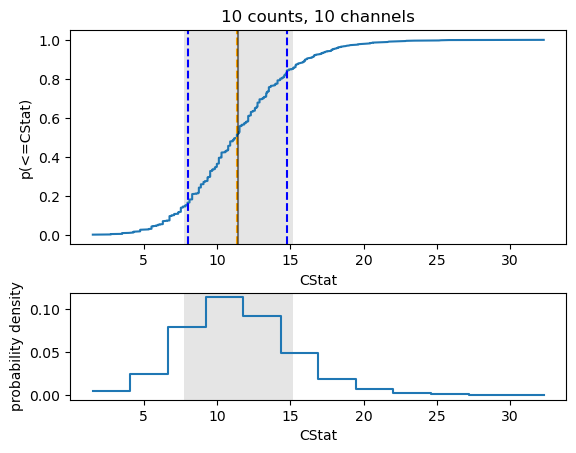

In [36]:
doit(10, 10)

## 100 channels

In this case the signal per channel ranges from 10 to 0.1.

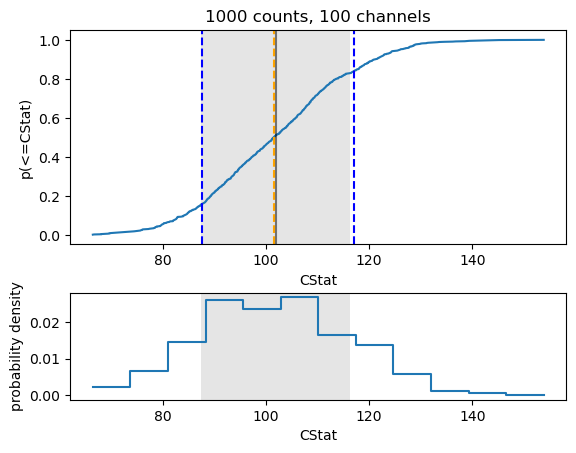

In [37]:
doit(100, 1000)

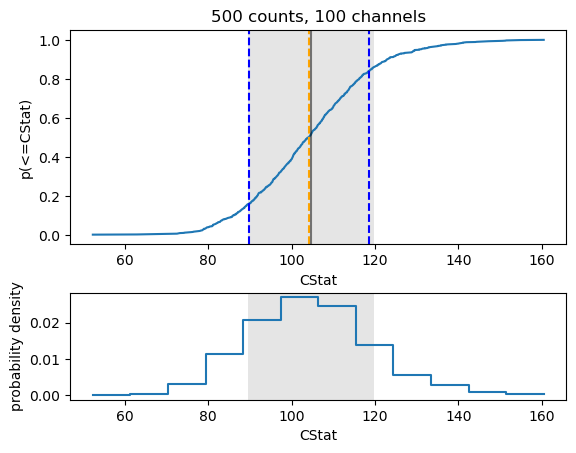

In [38]:
doit(100, 500)

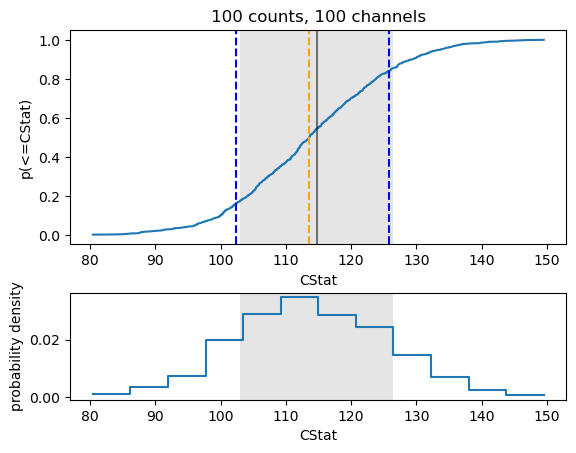

In [39]:
doit(100, 100)

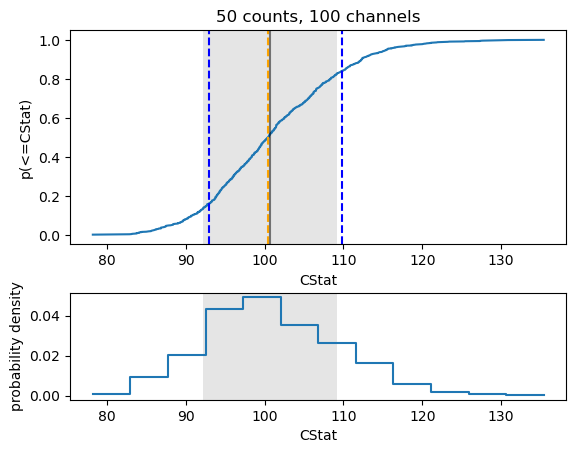

In [40]:
doit(100, 50)

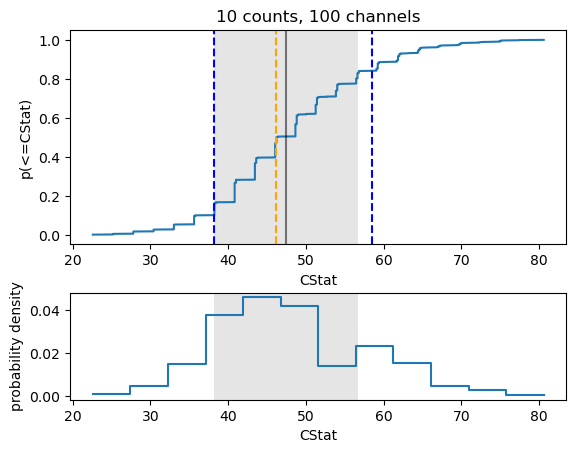

In [41]:
doit(100, 10)

The step nature of the statistic here is because the number of unique count distributions (ignoring which bins they fall into) for 10 counts is small$^\dagger$, so with enough realizations we end up re-creating the same data, leading to these steps.

---

$\dagger$ - there are 42 different ways to distribute 10 counts, but as the simulations do not force the simulated data to have exactly the predicted counts the actual number of combinations is somewhat higher.

## 1000 channels

Here the signal per channel starts at 1 and then drops to 0.01.

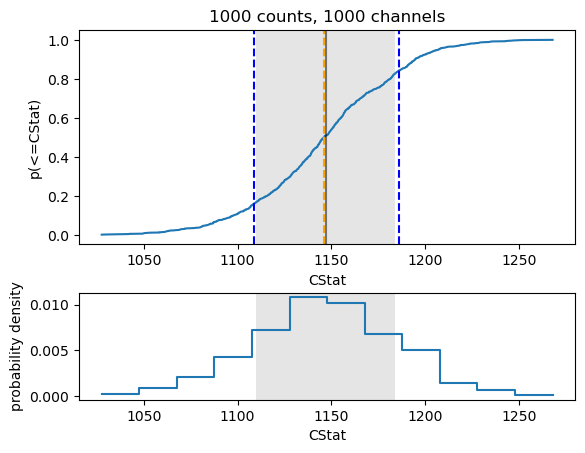

In [42]:
doit(1000, 1000)

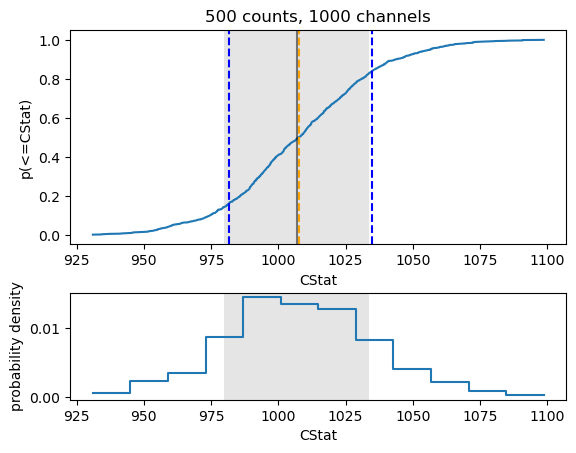

In [43]:
doit(1000, 500)

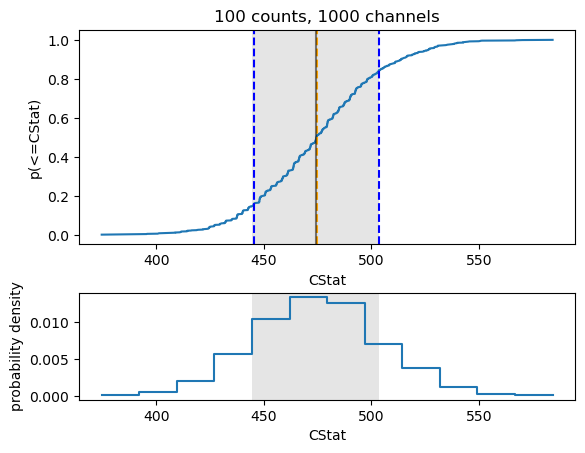

In [44]:
doit(1000, 100)

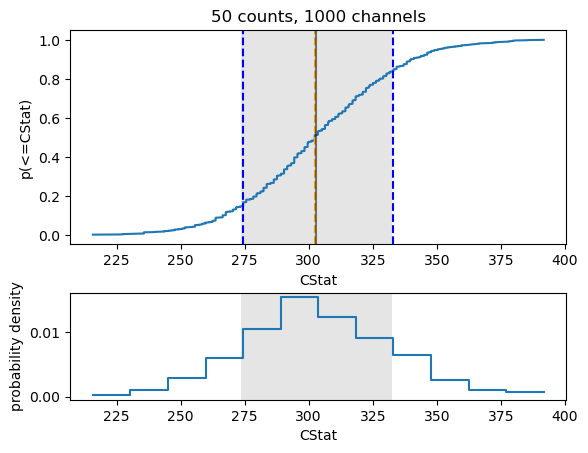

In [45]:
doit(1000, 50)

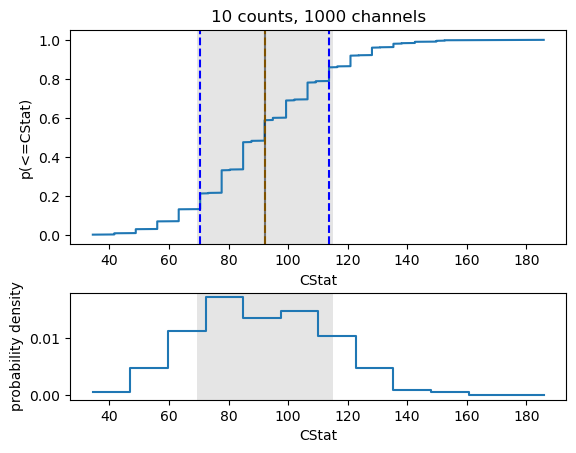

In [46]:
doit(1000, 10)

So, the simulations agree well with the Kaastra 17 approximations.